# Introduction to SPTK.jl

This notebook gives a brief instroduction to SPTK.jl, a Julia wrapper of [Speech Signal Processing Toolkit (SPTK)](http://sp-tk.sourceforge.net/).

- Reading and visualize waveform
- Windowing
- Spectral envelope estimation by mel-generalized cesptrum analysis 
- Vec-to-vec transform to mat-to-mat transform
- F0 estimation
- Source excitation generation

## Requirements

- SPTK
- WAV
- PyPlot

In [1]:
### Plotting settings ### 
# Configure plottinig settings (using `PyPlot` in this notebook)

using PyCall
using PyPlot
PyDict(matplotlib["rcParams"])["figure.figsize"] = (12, 5);

## Data

In [2]:
using WAV
import SPTK

INFO: Recompiling stale cache file /home/ryuichi/.julia/lib/v0.4/SPTK.ji for module SPTK.


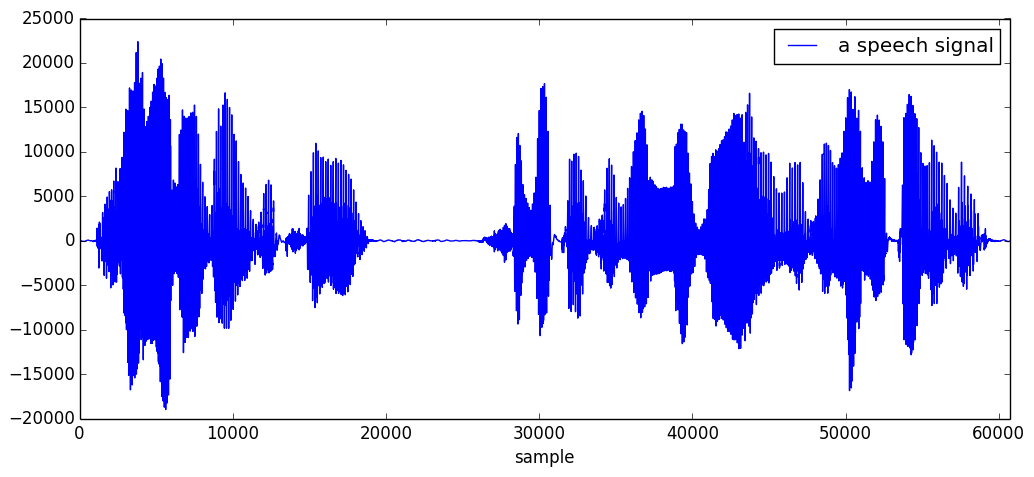

PyObject <matplotlib.legend.Legend object at 0x7f9ac8158850>

In [3]:
filepath = joinpath(Pkg.dir("SPTK"), "examples", "test16k.wav")
x, fs = wavread(filepath, format="native")
x = convert(Vector{Float64}, vec(x)) # monoral
fs = convert(Int, fs)

# Visualize the speech signal in time-domain
plot(1:endof(x), x, label="a speech signal")
xlim(1, endof(x))
xlabel("sample")
legend()

## Windowing

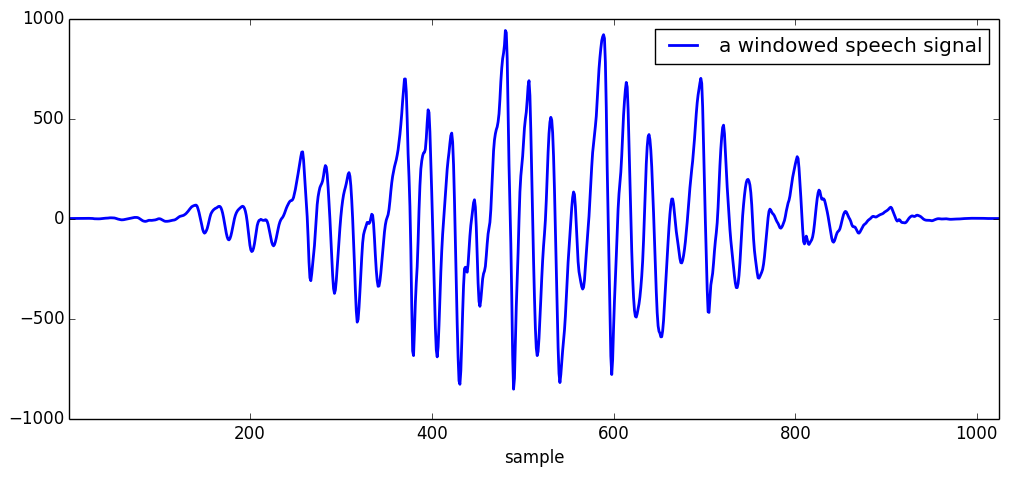

PyObject <matplotlib.legend.Legend object at 0x7f9ac7dbe450>

In [4]:
# Pick a short segment
pos = 3000
fftlen = 1024
# Note that mel-generalized cepstrum analysis basically assumes window is power-normalized.
xw = x[pos+1:pos+fftlen] .* SPTK.blackman(fftlen)

plot(1:endof(xw), xw, linewidth="2", label="a windowed speech signal")
xlim(1, endof(xw))
xlabel("sample")
legend()

## Mel-generalized cepstrum analysis

In [5]:
# Plotting utility for visualizing spectral envelope estimate
function pplot(sp, envelope; title="envelope")
    plot(sp, "b-", linewidth="2", label="Original log spectrum 20log|X(ω)|")
    plot(20/log(10)*(envelope), "r-", linewidth="3", label=title)
    xlim(1, length(sp))
    xlabel("frequency bin")
    ylabel("log amplitude")
    legend()
end

pplot (generic function with 1 method)

In [6]:
# Compute spectrum 20log|X(ω)| for a windowed signal
sp = 20log10(abs(rfft(xw)));

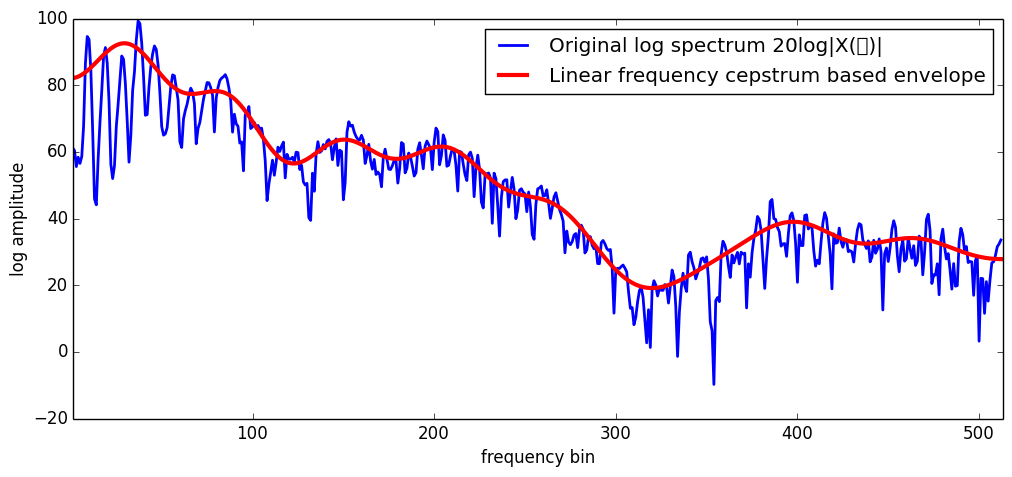

PyObject <matplotlib.legend.Legend object at 0x7f9ac74a85d0>

In [7]:
# Linear Cepstrum
c = SPTK.mgcep(xw, 20, 0.0, 0.0)
pplot(sp, real(SPTK.mgc2sp(c, 0.0, 0.0, fftlen)), title="Linear frequency cepstrum based envelope")

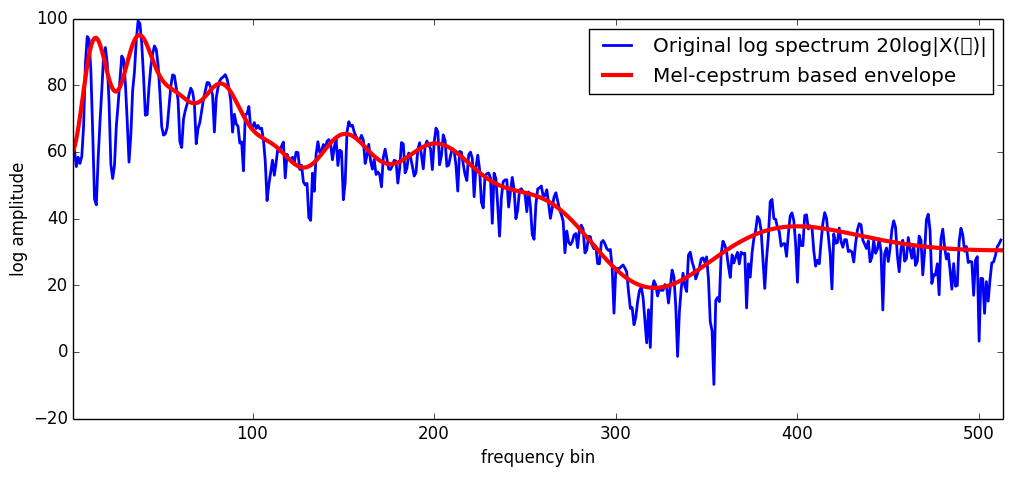

PyObject <matplotlib.legend.Legend object at 0x7f9ac73f4450>

In [8]:
# Mel-Cepstrum
mc = SPTK.mcep(xw, 20, 0.41)
pplot(sp, real(SPTK.mgc2sp(mc, 0.41, 0.0, fftlen)), title="Mel-cepstrum based envelope")

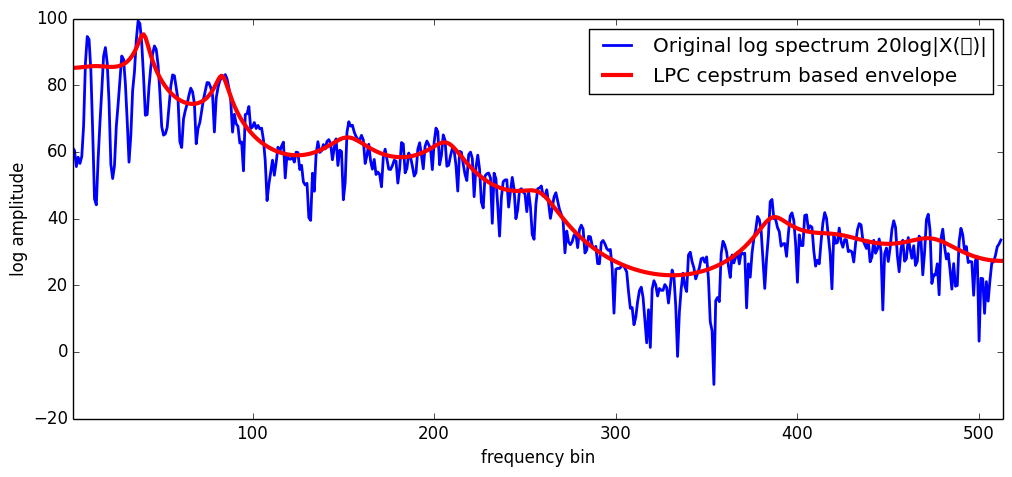

PyObject <matplotlib.legend.Legend object at 0x7f9ac73372d0>

In [9]:
# LPC Cepstrum 
mgc = SPTK.mgcep(xw, 20, 0.0, -1.0)
pplot(sp, real(SPTK.mgc2sp(mgc, 0.0, -1.0, fftlen)), title="LPC cepstrum based envelope")

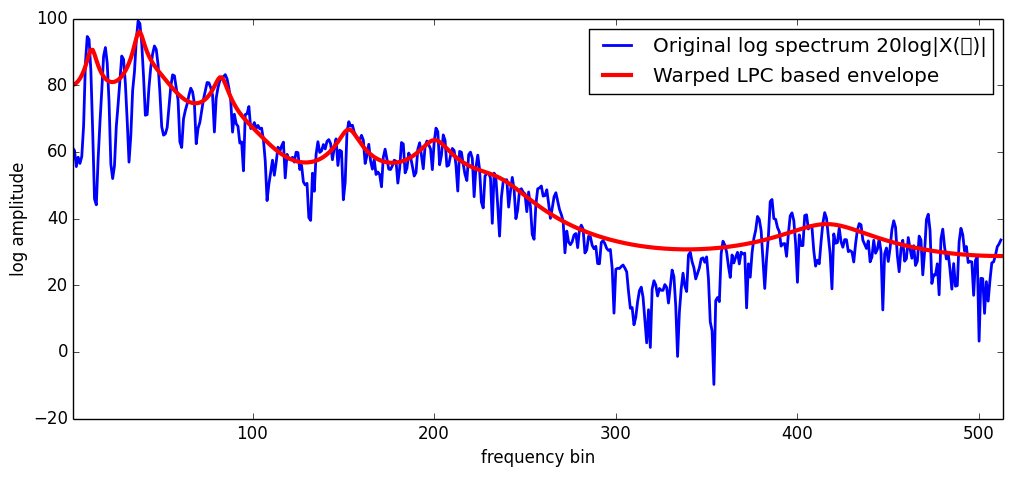

PyObject <matplotlib.legend.Legend object at 0x7f9ac727a050>

In [10]:
# Warped LPC
mgc = SPTK.mgcep(xw, 20, 0.41, -1.0)
pplot(sp, real(SPTK.mgc2sp(mgc, 0.41, -1.0, fftlen)), title="Warped LPC based envelope")

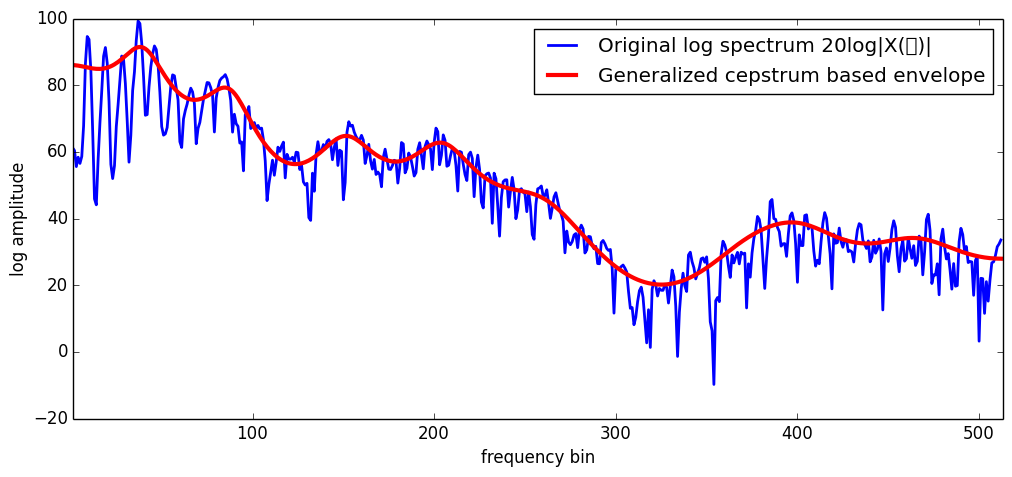

PyObject <matplotlib.legend.Legend object at 0x7f9ac71b4d50>

In [11]:
# Generalized Cepstrum
mgc = SPTK.gcep(xw, 20, -0.35)
pplot(sp, real(SPTK.mgc2sp(mgc, 0.0, -0.35, fftlen)), title="Generalized cepstrum based envelope")

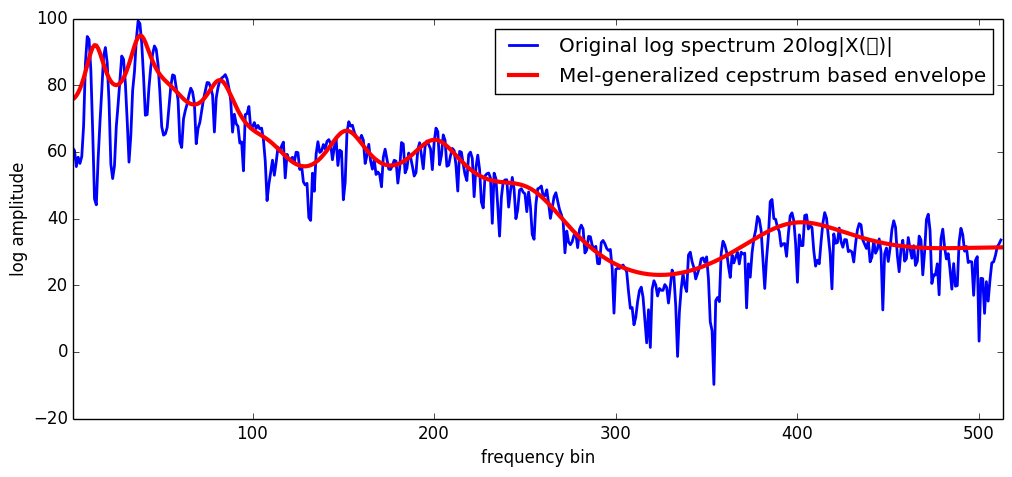

PyObject <matplotlib.legend.Legend object at 0x7f9ac70f7a10>

In [12]:
# Mel-Generalized Cepstrum
mgc = SPTK.mgcep(xw, 20, 0.41, -0.35)
pplot(sp, real(SPTK.mgc2sp(mgc, 0.41, -0.35, fftlen)), title="Mel-generalized cepstrum based envelope")

## Matrix-to-matrix transform

Almost all of vec2vec transforms have its mat2mat (col-wise) functions. Demonstrations are below.

In [13]:
# Utilities for splitting a time sequence into overlapping frames
countframes(x::AbstractVector, framelen, hopsize) = div(length(x) - framelen, hopsize) + 1

function splitframes(x::AbstractVector, framelen=1024, hopsize=framelen>>1)
    N = countframes(x, framelen, hopsize)
    frames = Array(eltype(x), framelen, N)
    @inbounds for i = 1:N
        frames[:,i] = x[(i-1)*hopsize+1:(i-1)*hopsize+framelen]
    end
    frames
end

splitframes (generic function with 3 methods)

In [14]:
winlen = 1024
hopsize = winlen>>1
xw = splitframes(x, winlen, hopsize) .* SPTK.blackman(winlen);
@show size(xw)

size(xw) = (1024,117)

(1024,117)

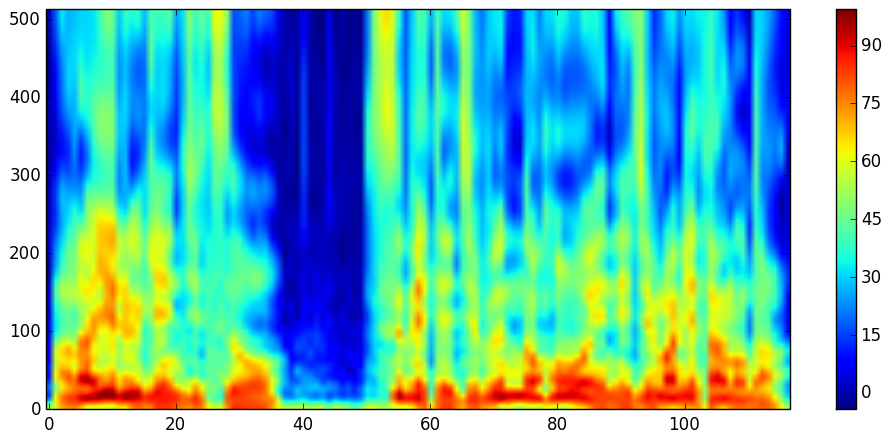

PyObject <matplotlib.colorbar.Colorbar instance at 0x7f9ac701f050>

In [15]:
# Let's see how spectral envelope estimates are changed with different order of mel-cepstrum
# Estimate spectral envelope by mel-cepstrum analysis where order = 20
logsp = real(SPTK.mgc2sp(SPTK.mcep(xw, 20, 0.41), 0.41, 0.0, winlen))
imshow(20/log(10)*logsp, origin="lower", aspect="auto")
colorbar()

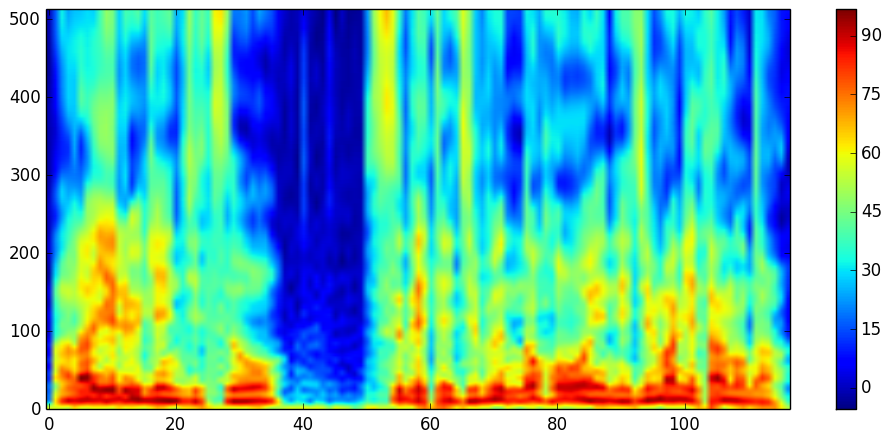

PyObject <matplotlib.colorbar.Colorbar instance at 0x7f9ac6e6e998>

In [16]:
# order = 30
logsp = real(SPTK.mgc2sp(SPTK.mcep(xw, 30, 0.41), 0.41, 0.0, winlen))
imshow(20/log(10)*logsp, origin="lower", aspect="auto")
colorbar()

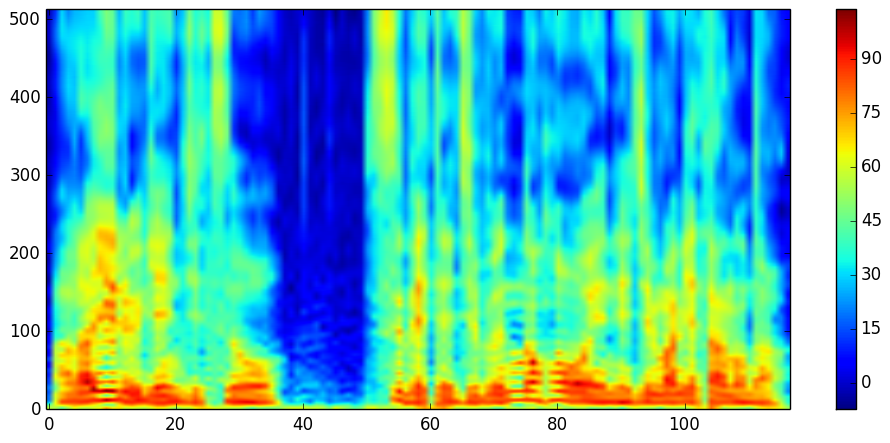

PyObject <matplotlib.colorbar.Colorbar instance at 0x7f9ac6d30a70>

In [17]:
# order = 40
logsp = real(SPTK.mgc2sp(SPTK.mcep(xw, 40, 0.41), 0.41, 0.0, winlen))
imshow(20/log(10)*logsp, origin="lower", aspect="auto")
colorbar()

## F0 estimation

SPTK supports two algorithms below:

- SWIPE'
- RAPT

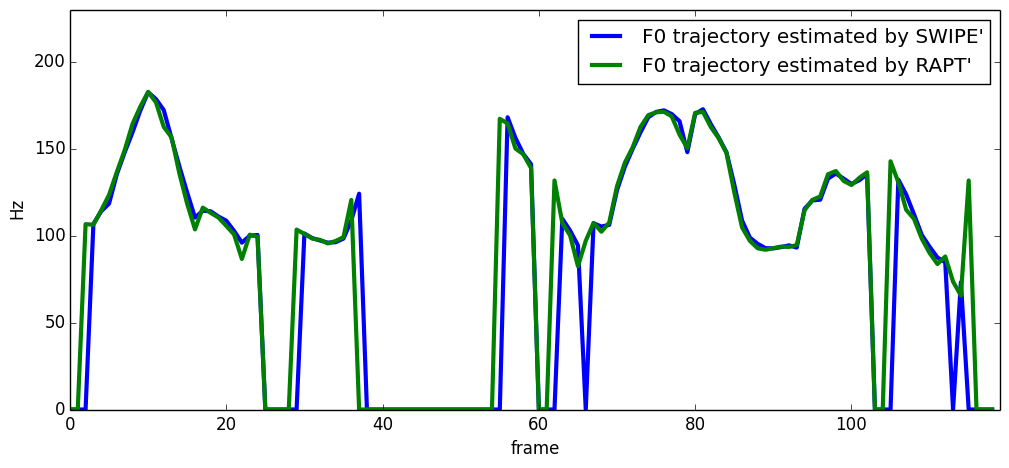

PyObject <matplotlib.legend.Legend object at 0x7f9ac6c8fe50>

In [18]:
# SWIPE'
f0_swipe = SPTK.swipe(x, fs, hopsize, otype=1)
plot(f0_swipe, label="F0 trajectory estimated by SWIPE'", linewidth=3)

# RAPT
f0_rapt = SPTK.rapt(map(Float32, x), fs, hopsize, otype=1)
plot(f0_rapt, label="F0 trajectory estimated by RAPT'", linewidth=3)

xlim(0, length(f0_rapt))
ylim(0, 230)
xlabel("frame")
ylabel("Hz")
legend()

## Source excitation generation

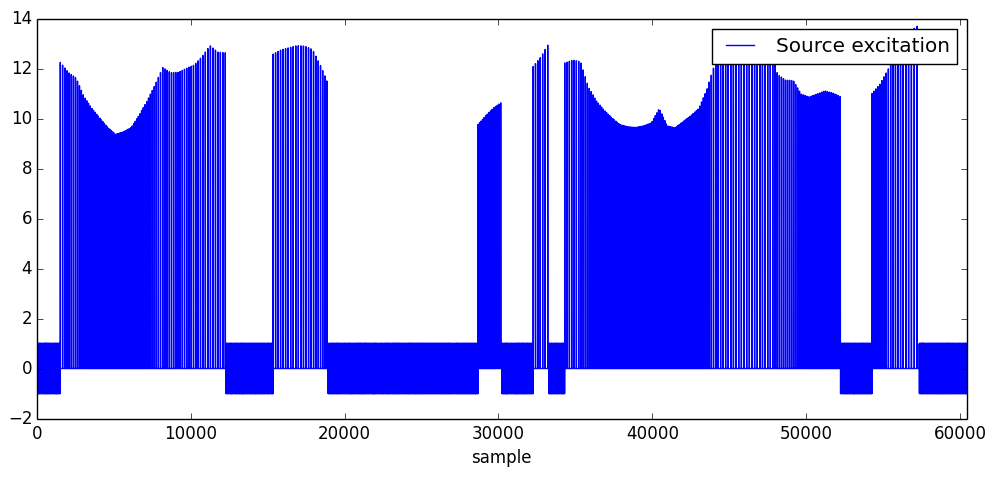

PyObject <matplotlib.legend.Legend object at 0x7f9ac6bc0110>

In [19]:
pitch = SPTK.swipe(x, fs, hopsize, otype=0)
ex = SPTK.excite(pitch, hopsize, gaussian=false)
plot(ex, label="Source excitation")
xlim(0, length(ex))
xlabel("sample")
legend()